In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from numpy import concatenate
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE 
import json
import numpy as np

<font size="5"><b>Przygotowanie cech</b></font>

In [7]:
df_features = pd.read_csv('features_no_cat_names.csv')
df_faces = pd.read_csv('tn_faces.csv')

In [9]:
df_features

,publishedAt_hour,title_len,title_capitalised,title_punctuation,description_capitalised,description_punctuation,description_len,filtered_tags,tags_len,trending_days,...,Blue,Intensity,objects,Emotion,Age,Gender,Race,person_count,org_categories,ground_truth
0,19,34,True,True,False,True,362,"{'prank', 'funny', 'brother', 'mama', 'ghost',...",18,7,...,162852251,506510550,"['person', 'person']",happy,31.0,Man,latino hispanic,2,NaN,22.0
1,17,60,False,True,False,True,716,"{'fun', 'titanfall', 'origin', 'royale', 'mult...",27,5,...,44517027,199825645,[],neutral,34.0,Man,white,0,20.0,20.0
2,16,53,False,True,False,True,514,"{'compilation', 'dank', 'fan', 'memes', 'jacks...",23,7,...,83089369,303325705,"['person', 'tie', 'banana']",angry,37.0,Man,middle eastern,1,NaN,24.0
3,16,56,False,True,False,True,763,"{'rapper', 'hip', 'keem', 'xxl', 'rap', 'wave'...",28,5,...,103429243,348247070,"['train', 'stop sign', 'person', 'person', 'pe...",happy,22.0,Man,black,5,NaN,10.0
4,15,55,False,True,False,True,2494,"{'movie', 'theater', 'savannah', 'makeover', '...",38,6,...,99107318,359889150,"['person', 'person', 'person', 'person', 'pers...",fear,25.0,Man,white,7,NaN,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20826,22,46,False,True,False,True,400,"{'minecraftmeme', 'java', 'minecraft', 'smp', ...",22,1,...,35955973,113878704,[],NaN,NaN,NaN,NaN,0,20.0,20.0
20827,18,41,False,True,False,True,482,"{'pearlescentmoon', 'lets', 'season', 'new', '...",10,1,...,2094623,6283869,['cell phone'],NaN,NaN,NaN,NaN,0,NaN,20.0
20828,1,36,False,True,False,False,1,{'none'},1,1,...,43191421,130422931,"['bottle', 'cup', 'dining table', 'cup', 'cake...",NaN,NaN,NaN,NaN,1,NaN,24.0
20829,22,37,False,True,False,False,1,{'none'},1,1,...,54719173,179954453,"['person', 'person', 'person', 'laptop', 'cell...",NaN,NaN,NaN,NaN,3,NaN,24.0


<b>Usunięcie nieprzydatnych atrybutów</b>

In [12]:
df_features = df_features.drop(['Red', 'Green', 'Blue', 'description_punctuation', 'trending_days', 'entropy', 'Age', 'filtered_tags', 'objects'], axis=1)

In [13]:
df_features

,publishedAt_hour,title_len,title_capitalised,title_punctuation,description_capitalised,description_len,tags_len,tags_based_category,Intensity,Emotion,Gender,Race,person_count,org_categories,ground_truth
0,19,34,True,True,False,362,18,style,506510550,happy,Man,latino hispanic,2,NaN,22.0
1,17,60,False,True,False,716,27,gaming,199825645,neutral,Man,white,0,20.0,20.0
2,16,53,False,True,False,514,23,music,303325705,angry,Man,middle eastern,1,NaN,24.0
3,16,56,False,True,False,763,28,music,348247070,happy,Man,black,5,NaN,10.0
4,15,55,False,True,False,2494,38,style,359889150,fear,Man,white,7,NaN,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20826,22,46,False,True,False,400,22,gaming,113878704,NaN,NaN,NaN,0,20.0,20.0
20827,18,41,False,True,False,482,10,music,6283869,NaN,NaN,NaN,0,NaN,20.0
20828,1,36,False,True,False,1,1,politics,130422931,NaN,NaN,NaN,1,NaN,24.0
20829,22,37,False,True,False,1,1,politics,179954453,NaN,NaN,NaN,3,NaN,24.0


<b>One hot encoding dla cech kategorycznych</b>

In [14]:
df_emotions = pd.get_dummies(df_faces.Emotion, prefix="Emotion")

In [15]:
df_gender = pd.get_dummies(df_faces.Gender, prefix="Gender")

In [16]:
df_race = pd.get_dummies(df_faces.Race, prefix="Race")

In [17]:
df_tags_based_category = pd.get_dummies(df_features.tags_based_category, prefix="TagCategory")

In [18]:
df = pd.concat([df_features, df_emotions, df_gender, df_race, df_tags_based_category], axis=1)

In [19]:
df = df.drop(['Emotion', "Gender", "Race", "tags_based_category"], axis=1)

In [29]:
df["title_capitalised"] = df["title_capitalised"].astype(int)
df["title_punctuation"] = df["title_punctuation"].astype(int)
df["description_capitalised"] = df["description_capitalised"].astype(int)

In [32]:
#df.to_csv('df_feat_prepared', index=False)

In [3]:
#df = pd.read_csv('df_feat_prepared')

In [4]:
#eksperymenty dla pierwszych 12.5k elementow, poniewaz dla tylu posiadam wszystkie atrybuty (dla tylu próbek udało się pozyskać cechy z miniatur)
df = df.iloc[:12500]

In [5]:
df

,publishedAt_hour,title_len,title_capitalised,title_punctuation,description_capitalised,description_len,tags_len,Intensity,person_count,org_categories,...,TagCategory_howto,TagCategory_music,TagCategory_news,TagCategory_politics,TagCategory_science,TagCategory_sport,TagCategory_style,TagCategory_technology,TagCategory_travel,TagCategory_vehicle
0,19,34,1,1,0,362,18,506510550,2,NaN,...,0,0,0,0,0,0,1,0,0,0
1,17,60,0,1,0,716,27,199825645,0,20.0,...,0,0,0,0,0,0,0,0,0,0
2,16,53,0,1,0,514,23,303325705,1,NaN,...,0,1,0,0,0,0,0,0,0,0
3,16,56,0,1,0,763,28,348247070,5,NaN,...,0,1,0,0,0,0,0,0,0,0
4,15,55,0,1,0,2494,38,359889150,7,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,14,79,0,1,0,2479,11,271563625,5,NaN,...,0,0,0,0,0,0,0,0,0,0
12496,17,22,0,1,1,855,13,236506600,3,1.0,...,0,0,0,0,0,0,0,0,0,0
12497,14,86,0,1,0,648,12,275587603,1,20.0,...,0,0,0,0,0,0,0,0,0,0
12498,23,73,0,1,0,967,44,248935945,3,NaN,...,0,1,0,0,0,0,0,0,0,0


<b>Skalowanie cech</b>

In [6]:
scaler = MinMaxScaler()
df[['publishedAt_hour', 'title_len', 'description_len', 'tags_len', 'Intensity', 'person_count']] = scaler.fit_transform(df[['publishedAt_hour', 'title_len', 'description_len', 'tags_len', 'Intensity', 'person_count']])

In [7]:
df

,publishedAt_hour,title_len,title_capitalised,title_punctuation,description_capitalised,description_len,tags_len,Intensity,person_count,org_categories,...,TagCategory_howto,TagCategory_music,TagCategory_news,TagCategory_politics,TagCategory_science,TagCategory_sport,TagCategory_style,TagCategory_technology,TagCategory_travel,TagCategory_vehicle
0,0.826087,0.319588,1,1,0,0.072229,0.268657,0.735234,0.051282,NaN,...,0,0,0,0,0,0,1,0,0,0
1,0.739130,0.587629,0,1,0,0.143057,0.402985,0.288100,0.000000,20.0,...,0,0,0,0,0,0,0,0,0,0
2,0.695652,0.515464,0,1,0,0.102641,0.343284,0.438999,0.025641,NaN,...,0,1,0,0,0,0,0,0,0,0
3,0.695652,0.546392,0,1,0,0.152461,0.417910,0.504492,0.128205,NaN,...,0,1,0,0,0,0,0,0,0,0
4,0.652174,0.536082,0,1,0,0.498800,0.567164,0.521466,0.179487,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.608696,0.783505,0,1,0,0.495798,0.164179,0.392691,0.128205,NaN,...,0,0,0,0,0,0,0,0,0,0
12496,0.739130,0.195876,0,1,1,0.170868,0.194030,0.341580,0.076923,1.0,...,0,0,0,0,0,0,0,0,0,0
12497,0.608696,0.855670,0,1,0,0.129452,0.179104,0.398558,0.025641,20.0,...,0,0,0,0,0,0,0,0,0,0
12498,1.000000,0.721649,0,1,0,0.193277,0.656716,0.359701,0.076923,NaN,...,0,1,0,0,0,0,0,0,0,0


<b>Rozkład kategorii</b>

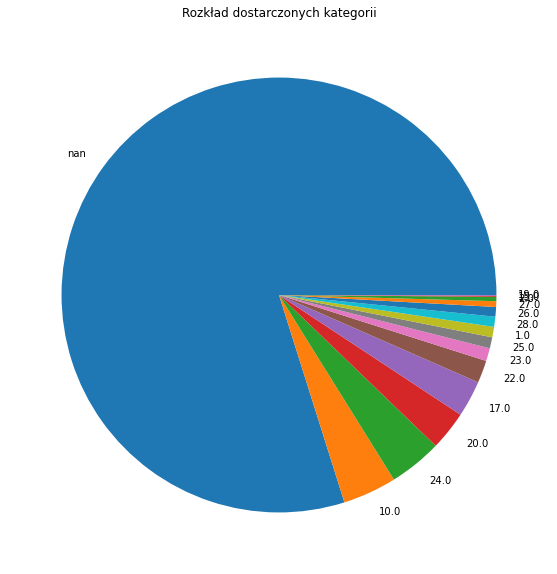

NaN     9983
10.0     500
24.0     493
20.0     364
17.0     338
22.0     209
23.0     120
25.0     103
1.0       97
28.0      94
26.0      89
27.0      53
2.0       40
15.0       9
19.0       8
Name: org_categories, dtype: int64


In [8]:
cat_amount=df['org_categories'].value_counts(dropna=False)
plt.figure(figsize=(10, 10))
plt.title("Rozkład dostarczonych kategorii")
plt.pie(cat_amount, labels = cat_amount.index)
plt.show()
print(cat_amount)

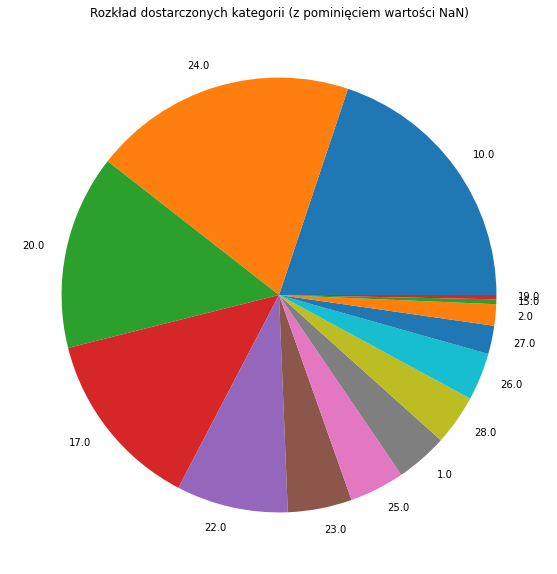

10.0    500
24.0    493
20.0    364
17.0    338
22.0    209
23.0    120
25.0    103
1.0      97
28.0     94
26.0     89
27.0     53
2.0      40
15.0      9
19.0      8
Name: org_categories, dtype: int64


In [10]:
#bez nan
cat_amount=df['org_categories'].value_counts()
plt.figure(figsize=(10, 10))
plt.title("Rozkład dostarczonych kategorii (z pominięciem wartości NaN)")
plt.pie(cat_amount, labels = cat_amount.index)
plt.show()
print(cat_amount)


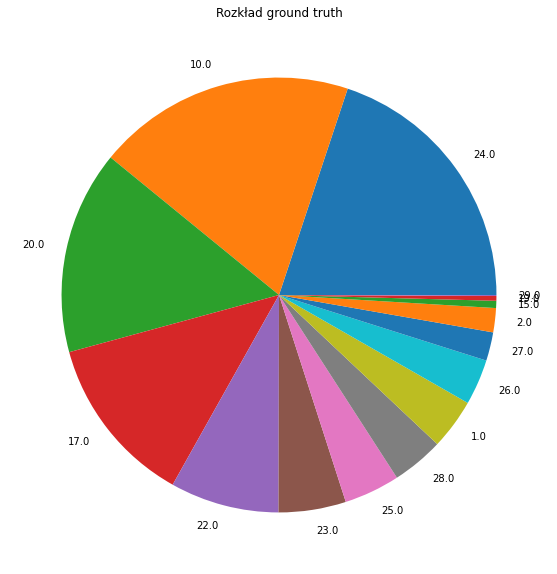

24.0    2427
10.0    2346
20.0    1847
17.0    1542
22.0     988
23.0     611
25.0     507
28.0     470
1.0      459
26.0     414
27.0     259
2.0      219
15.0      65
19.0      43
29.0       9
Name: ground_truth, dtype: int64


In [11]:
#ground truth
cat_amount=df['ground_truth'].value_counts()
plt.figure(figsize=(10, 10))
plt.title("Rozkład ground truth")
plt.pie(cat_amount, labels = cat_amount.index)
plt.show()
print(cat_amount)

<b>Podział danych na etykietowane oraz nieetykietowane. Przygotowanie danych uczących i treningowych</b>

In [8]:
labeled = df[df['org_categories'] == df['org_categories']]
labeled['org_categories']

1        20.0
5        24.0
6        26.0
7        27.0
9        10.0
         ... 
12488    27.0
12490    10.0
12494    17.0
12496     1.0
12497    20.0
Name: org_categories, Length: 2517, dtype: float64

In [9]:
unlabeled = df[df['org_categories'] != df['org_categories']]
unlabeled['org_categories']

0       NaN
2       NaN
3       NaN
4       NaN
8       NaN
         ..
12492   NaN
12493   NaN
12495   NaN
12498   NaN
12499   NaN
Name: org_categories, Length: 9983, dtype: float64

In [10]:
#dane treningowe etykietowane
X_train_lab = labeled.drop(['org_categories', 'ground_truth'], axis=1)
y_train_lab = labeled['org_categories']

In [11]:
#dane treningowe i testowe nieetykietowane (wydzielenie z danych nieetykietowanych na te do treningu oraz do testów [ground truth])
X_train_unlab, X_test, y_train_unlab, y_test = train_test_split(unlabeled.drop(['org_categories', 'ground_truth'], axis=1), unlabeled[['org_categories', 'ground_truth']], test_size=0.5, random_state=42)
y_train_unlab = y_train_unlab['org_categories']
y_test = y_test['ground_truth']

In [12]:
#usunięcie wartosci nan ze zbiorow testowych
for index, value in y_test.items():
     if value != value:
        y_test.drop(index, inplace = True)
        X_test.drop(index, inplace = True) 

In [13]:
print("Etykietowany zbiór uczący: ",  X_train_lab.shape, y_train_lab.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (2517, 46) (2517,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


In [14]:
#LabelPropagation wymaga, aby unlabeled y posiadał wartości -1
y_train_unlab = y_train_unlab.fillna(-1)

In [15]:
#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab, X_train_unlab))
y_train = concatenate((y_train_lab, y_train_unlab))

<font size="5"><b>Label Propagation z zachowaniem wszystkich dostępnych kategorii</b></font>

In [23]:
lp = LabelPropagation()
lp.fit(X_train, y_train)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


LabelPropagation()

In [24]:
y_pred = lp.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LabelPropagation was fitted without feature names
  warnings.warn(


Accuracy score:  0.40630797773654914
G-mean score:  0.6043800842685338


In [38]:
geometric_mean_score(y_test, y_pred, average=None, labels = [1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28])

array([0.3562246 , 0.46339022, 0.7606797 , 0.26698403, 0.80868475,
       0.24235996, 0.65769153, 0.35388704, 0.30868702, 0.47442573,
       0.4889506 , 0.43132671, 0.48163926, 0.44849512])

<font size="5"><b>Label propagation z połączeniem 3 najmniej licznych kategorii</b></font>

In [51]:
#Połączenie 3 najmniej licznych kategorii; przypisanie im numeru 0
for index, row in df.iterrows():
    if row['org_categories'] in [2.0, 15.0, 19.0]:
        df['org_categories'][index] = 0
    if row['ground_truth'] in [2.0, 15.0, 19.0]:
        df['ground_truth'][index] = 0

C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/1519175875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ground_truth'][index] = 0
C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/1519175875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['org_categories'][index] = 0


In [114]:
#przygotowanie danych pod trening
labeled = df[df['org_categories'] == df['org_categories']]
unlabeled = df[df['org_categories'] != df['org_categories']]

#dane treningowe etykietowane
X_train_lab = labeled.drop(['org_categories', 'ground_truth'], axis=1)
y_train_lab = labeled['org_categories']

#dane treningowe i testowe nieetykietowane (wydzielenie z danych nieetykietowanych na te do treningu oraz do testów [ground truth])
X_train_unlab, X_test, y_train_unlab, y_test = train_test_split(unlabeled.drop(['org_categories', 'ground_truth'], axis=1), unlabeled[['org_categories', 'ground_truth']], test_size=0.5, random_state=42)
y_train_unlab = y_train_unlab['org_categories']
y_test = y_test['ground_truth']

#usunięcie wartosci nan ze zbiorow testowych
for index, value in y_test.items():
     if value != value:
        y_test.drop(index, inplace = True)
        X_test.drop(index, inplace = True)  
        
#LabelPropagation wymaga, aby unlabeled y posiadał wartości -1
y_train_unlab = y_train_unlab.fillna(-1)

#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab, X_train_unlab))
y_train = concatenate((y_train_lab, y_train_unlab))

print("Etykietowany zbiór uczący: ",  X_train_lab.shape, y_train_lab.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (2517, 46) (2517,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


In [54]:
lp = LabelPropagation()
lp.fit(X_train, y_train)

y_pred = lp.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LabelPropagation was fitted without feature names
  warnings.warn(


Accuracy score:  0.406720263863121
G-mean score:  0.6046455480360707


In [70]:
labels = [ 0.,  1., 10., 17., 20., 22., 23., 24., 25., 26., 27., 28.]
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  0.0  Wynik:  0.4229456056460664
Kategoria:  1.0  Wynik:  0.35622459544674384
Kategoria:  10.0  Wynik:  0.7606796984110377
Kategoria:  17.0  Wynik:  0.8086847526477338
Kategoria:  20.0  Wynik:  0.6576915299655263
Kategoria:  22.0  Wynik:  0.35388703888475076
Kategoria:  23.0  Wynik:  0.30868701707296325
Kategoria:  24.0  Wynik:  0.47442573452460485
Kategoria:  25.0  Wynik:  0.4889505984826898
Kategoria:  26.0  Wynik:  0.43132670680472573
Kategoria:  27.0  Wynik:  0.4816392595002213
Kategoria:  28.0  Wynik:  0.4484951230429219


<font size="5"><b>Label propagation z zachowaniem 5 najbardziej licznych kategorii</b></font>

In [98]:
#Zostawienie top 5 kategorii
for index, row in df.iterrows():
    if row['org_categories'] in [23.0, 25.0, 1.0, 28.0, 26.0, 27.0, 2.0, 15.0, 19.0]:
        df['org_categories'][index] = 0
    if row['ground_truth'] in [23.0, 25.0, 1.0, 28.0, 26.0, 27.0, 2.0, 15.0, 19.0]:
        df['ground_truth'][index] = 0

C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/3114357206.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ground_truth'][index] = 0
C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/3114357206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['org_categories'][index] = 0


In [101]:
#przygotowanie danych pod trening
labeled = df[df['org_categories'] == df['org_categories']]
unlabeled = df[df['org_categories'] != df['org_categories']]

#dane treningowe etykietowane
X_train_lab = labeled.drop(['org_categories', 'ground_truth'], axis=1)
y_train_lab = labeled['org_categories']

#dane treningowe i testowe nieetykietowane (wydzielenie z danych nieetykietowanych na te do treningu oraz do testów [ground truth])
X_train_unlab, X_test, y_train_unlab, y_test = train_test_split(unlabeled.drop(['org_categories', 'ground_truth'], axis=1), unlabeled[['org_categories', 'ground_truth']], test_size=0.5, random_state=42)
y_train_unlab = y_train_unlab['org_categories']
y_test = y_test['ground_truth']

#usunięcie wartosci nan ze zbiorow testowych
for index, value in y_test.items():
     if value != value:
        y_test.drop(index, inplace = True)
        X_test.drop(index, inplace = True)  
        
#LabelPropagation wymaga, aby unlabeled y posiadał wartości -1
y_train_unlab = y_train_unlab.fillna(-1)

#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab, X_train_unlab))
y_train = concatenate((y_train_lab, y_train_unlab))

print("Etykietowany zbiór uczący: ",  X_train_lab.shape, y_train_lab.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (2517, 46) (2517,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


In [102]:
lp = LabelPropagation()
lp.fit(X_train, y_train)

y_pred = lp.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LabelPropagation was fitted without feature names
  warnings.warn(


Accuracy score:  0.44774273345701915
G-mean score:  0.6252656686694368


In [106]:
labels = [20., 24.,  0., 10., 22., 17.]
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  20.0  Wynik:  0.6516643070382956
Kategoria:  24.0  Wynik:  0.46535510471783514
Kategoria:  0.0  Wynik:  0.5634844028379461
Kategoria:  10.0  Wynik:  0.7610859856123308
Kategoria:  22.0  Wynik:  0.34715746277914633
Kategoria:  17.0  Wynik:  0.8040180017784996


<font size="5"><b>Self-training z zachowaniem wszystkich kategorii</b></font>

In [117]:
model_svc = SVC(kernel='rbf', 
                probability=True, 
                random_state=0
               )

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7, 
                                             criterion='threshold', 
                                             max_iter=100, 
                                             verbose=True 
                                            )

self_training_model.fit(X_train, y_train)

End of iteration 1, added 164 new labels.
End of iteration 2, added 220 new labels.
End of iteration 3, added 194 new labels.
End of iteration 4, added 94 new labels.
End of iteration 5, added 41 new labels.
End of iteration 6, added 17 new labels.
End of iteration 7, added 8 new labels.
End of iteration 8, added 9 new labels.
End of iteration 9, added 17 new labels.
End of iteration 10, added 6 new labels.
End of iteration 11, added 2 new labels.
End of iteration 12, added 3 new labels.
End of iteration 13, added 2 new labels.
End of iteration 14, added 2 new labels.
End of iteration 15, added 1 new labels.
End of iteration 16, added 1 new labels.
End of iteration 17, added 1 new labels.


SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=0),
                       max_iter=100, threshold=0.7, verbose=True)

In [118]:
y_pred = self_training_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy score:  0.44959802102659246
G-mean score:  0.6310563923310266


In [119]:
geometric_mean_score(y_test, y_pred, average=None, labels = [1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28])

array([0.30576846, 0.64699364, 0.8175773 , 0.        , 0.85869895,
       0.        , 0.66631331, 0.18610379, 0.14221578, 0.53849773,
       0.38693965, 0.        , 0.35584891, 0.52053898])

<font size="5"><b>Self-training z połączeniem 3 najmniej licznych kategorii </b></font>

In [121]:
#Połączenie 3 najmniej licznych kategorii
for index, row in df.iterrows():
    if row['org_categories'] in [2.0, 15.0, 19.0]:
        df['org_categories'][index] = 0
    if row['ground_truth'] in [2.0, 15.0, 19.0]:
        df['ground_truth'][index] = 0

C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/1519175875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ground_truth'][index] = 0
C:\Users\skibi\AppData\Local\Temp/ipykernel_19924/1519175875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['org_categories'][index] = 0


In [123]:
#przygotowanie danych pod trening
labeled = df[df['org_categories'] == df['org_categories']]
unlabeled = df[df['org_categories'] != df['org_categories']]

#dane treningowe etykietowane
X_train_lab = labeled.drop(['org_categories', 'ground_truth'], axis=1)
y_train_lab = labeled['org_categories']

#dane treningowe i testowe nieetykietowane (wydzielenie z danych nieetykietowanych na te do treningu oraz do testów [ground truth])
X_train_unlab, X_test, y_train_unlab, y_test = train_test_split(unlabeled.drop(['org_categories', 'ground_truth'], axis=1), unlabeled[['org_categories', 'ground_truth']], test_size=0.5, random_state=42)
y_train_unlab = y_train_unlab['org_categories']
y_test = y_test['ground_truth']

#usunięcie wartosci nan ze zbiorow testowych
for index, value in y_test.items():
     if value != value:
        y_test.drop(index, inplace = True)
        X_test.drop(index, inplace = True)  
        
#LabelPropagation wymaga, aby unlabeled y posiadał wartości -1
y_train_unlab = y_train_unlab.fillna(-1)

#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab, X_train_unlab))
y_train = concatenate((y_train_lab, y_train_unlab))

print("Etykietowany zbiór uczący: ",  X_train_lab.shape, y_train_lab.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (2517, 46) (2517,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


In [124]:
model_svc = SVC(kernel='rbf', 
                probability=True, 
                random_state=0
               )

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7, 
                                             criterion='threshold', 
                                             max_iter=100, 
                                             verbose=True 
                                            )

self_training_model.fit(X_train, y_train)

End of iteration 1, added 162 new labels.
End of iteration 2, added 215 new labels.
End of iteration 3, added 187 new labels.
End of iteration 4, added 101 new labels.
End of iteration 5, added 43 new labels.
End of iteration 6, added 16 new labels.
End of iteration 7, added 14 new labels.
End of iteration 8, added 6 new labels.
End of iteration 9, added 2 new labels.
End of iteration 10, added 1 new labels.


SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=0),
                       max_iter=100, threshold=0.7, verbose=True)

In [125]:
y_pred = self_training_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy score:  0.45248402391259535
G-mean score:  0.6331619027471462


In [126]:
labels = [ 0.,  1., 10., 17., 20., 22., 23., 24., 25., 26., 27., 28.]
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  0.0  Wynik:  0.5262672608759993
Kategoria:  1.0  Wynik:  0.30576846041234745
Kategoria:  10.0  Wynik:  0.8170596793610995
Kategoria:  17.0  Wynik:  0.8534610148722809
Kategoria:  20.0  Wynik:  0.6790083831137002
Kategoria:  22.0  Wynik:  0.18608287978600163
Kategoria:  23.0  Wynik:  0.1422157787949198
Kategoria:  24.0  Wynik:  0.5400857979328212
Kategoria:  25.0  Wynik:  0.4337690168611177
Kategoria:  26.0  Wynik:  0.0
Kategoria:  27.0  Wynik:  0.3558489065953874
Kategoria:  28.0  Wynik:  0.5205389774296215


<font size="5"><b>-------------Część dodana po prezentacji-------------</b></font>

<font size="5"><b>Oversampling</b></font>

In [16]:
oversample = RandomOverSampler(sampling_strategy='not majority')

In [17]:
X_train_lab_over, y_train_lab_over = oversample.fit_resample(X_train_lab, y_train_lab)

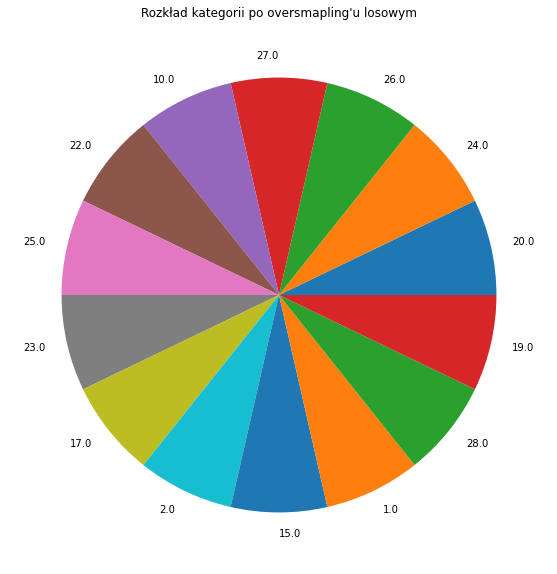

20.0    500
24.0    500
26.0    500
27.0    500
10.0    500
22.0    500
25.0    500
23.0    500
17.0    500
2.0     500
15.0    500
1.0     500
28.0    500
19.0    500
Name: org_categories, dtype: int64


In [18]:
cat_amount=y_train_lab_over.value_counts()
plt.figure(figsize=(10, 10))
plt.title("Rozkład kategorii po oversmapling'u losowym")
plt.pie(cat_amount, labels = cat_amount.index)
plt.show()
print(cat_amount)

In [21]:
#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab_over, X_train_unlab))
y_train = concatenate((y_train_lab_over, y_train_unlab))

In [23]:
print("Etykietowany zbiór uczący: ",  X_train_lab_over.shape, y_train_lab_over.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (7000, 46) (7000,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


<font size="5"><b>Self-training + Random Oversampling. Wszystkie kategorie</b></font>

In [26]:
model_svc = SVC(kernel='rbf', 
                probability=True, 
                random_state=0
               )

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7, 
                                             criterion='threshold', 
                                             max_iter=100, 
                                             verbose=True 
                                            )

self_training_model.fit(X_train, y_train)

End of iteration 1, added 881 new labels.
End of iteration 2, added 227 new labels.
End of iteration 3, added 119 new labels.
End of iteration 4, added 69 new labels.
End of iteration 5, added 37 new labels.
End of iteration 6, added 19 new labels.
End of iteration 7, added 30 new labels.
End of iteration 8, added 19 new labels.
End of iteration 9, added 11 new labels.
End of iteration 10, added 19 new labels.
End of iteration 11, added 10 new labels.
End of iteration 12, added 8 new labels.
End of iteration 13, added 13 new labels.
End of iteration 14, added 30 new labels.
End of iteration 15, added 13 new labels.
End of iteration 16, added 9 new labels.
End of iteration 17, added 15 new labels.
End of iteration 18, added 8 new labels.
End of iteration 19, added 6 new labels.
End of iteration 20, added 4 new labels.
End of iteration 21, added 4 new labels.


SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=0),
                       max_iter=100, threshold=0.7, verbose=True)

In [27]:
y_pred = self_training_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy score:  0.40507111935683365
G-mean score:  0.616541195549811


In [28]:
labels = [ 1.,  2., 10., 15., 17., 19., 20., 22., 23., 24., 25., 26., 27.,
       28.]
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  1.0  Wynik:  0.5005293954005624
Kategoria:  2.0  Wynik:  0.662419109184262
Kategoria:  10.0  Wynik:  0.7644827865696229
Kategoria:  15.0  Wynik:  0.42042502905879886
Kategoria:  17.0  Wynik:  0.8069767282227214
Kategoria:  19.0  Wynik:  0.23828383630373934
Kategoria:  20.0  Wynik:  0.6613210848607758
Kategoria:  22.0  Wynik:  0.4638621650118352
Kategoria:  23.0  Wynik:  0.4846036289372451
Kategoria:  24.0  Wynik:  0.25871025854476043
Kategoria:  25.0  Wynik:  0.693070026893241
Kategoria:  26.0  Wynik:  0.6061408076226902
Kategoria:  27.0  Wynik:  0.6216918354304466
Kategoria:  28.0  Wynik:  0.5477351822039693


In [29]:
#zmiana indeksów na nazwy kategorii
with open("US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
category=[]
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]

cat_dict
#df_features = features.copy()
#df_features['cat_name'] = features['ground_truth'].map(cat_dict)

labels_with_names = [*map(cat_dict.get, labels)]
labels_with_names

['Film & Animation',
 'Autos & Vehicles',
 'Music',
 'Pets & Animals',
 'Sports',
 'Travel & Events',
 'Gaming',
 'People & Blogs',
 'Comedy',
 'Entertainment',
 'News & Politics',
 'Howto & Style',
 'Education',
 'Science & Technology']

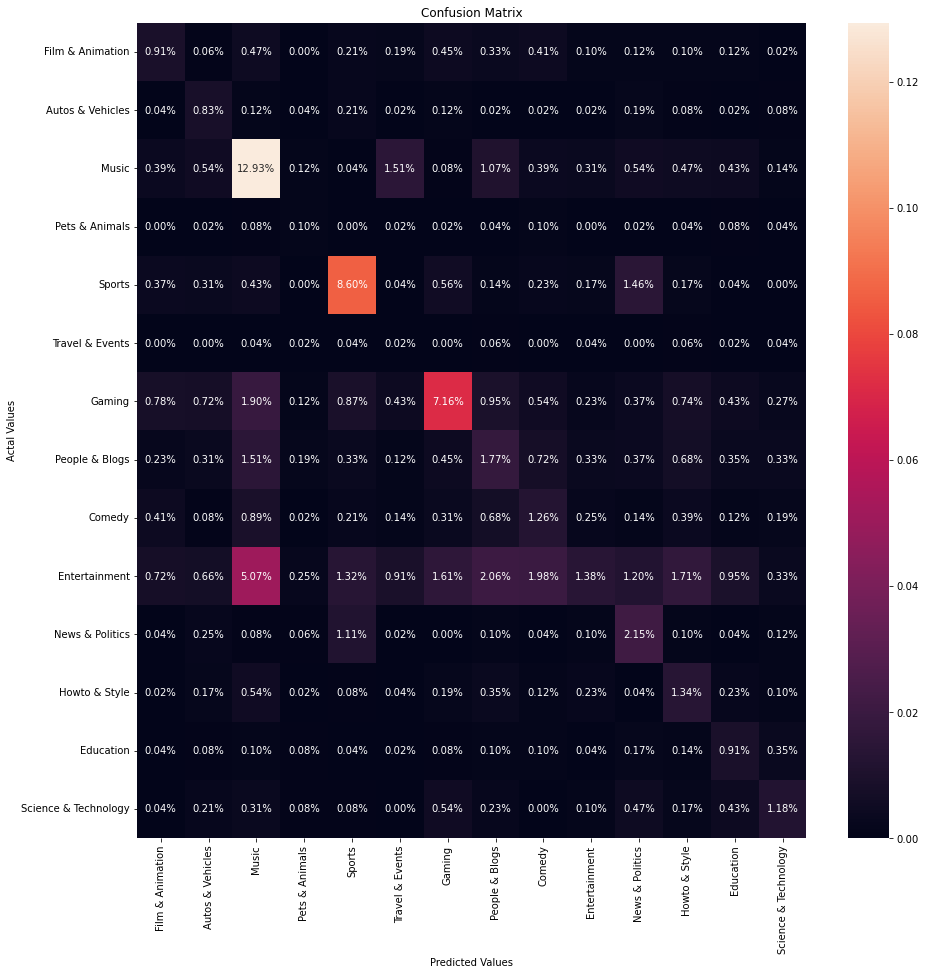

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
# cm_df = pd.DataFrame(cm,
#                      index = labels_with_names, 
#                      columns = labels_with_names)

plt.figure(figsize=(15,15))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', xticklabels = labels_with_names, yticklabels=labels_with_names)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<font size="5"><b>SMOTE</b></font>

In [31]:
oversample = SMOTE() #k =5

In [32]:
X_train_lab_over, y_train_lab_over = oversample.fit_resample(X_train_lab, y_train_lab)

In [34]:
#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab_over, X_train_unlab))
y_train = concatenate((y_train_lab_over, y_train_unlab))

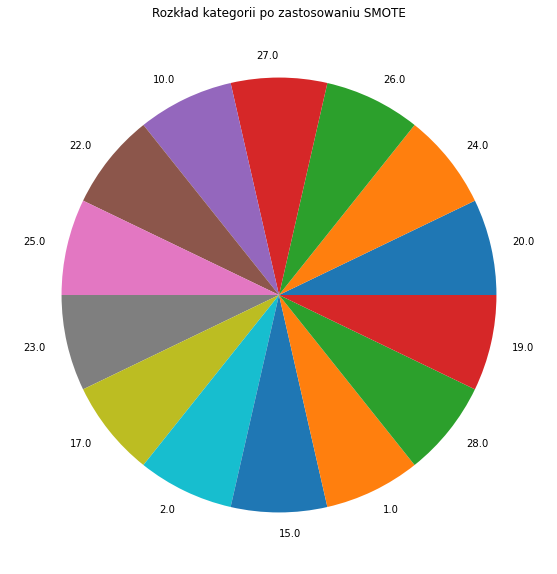

20.0    500
24.0    500
26.0    500
27.0    500
10.0    500
22.0    500
25.0    500
23.0    500
17.0    500
2.0     500
15.0    500
1.0     500
28.0    500
19.0    500
Name: org_categories, dtype: int64


In [35]:
cat_amount=y_train_lab_over.value_counts()
plt.figure(figsize=(10, 10))
plt.title("Rozkład kategorii po zastosowaniu SMOTE")
plt.pie(cat_amount, labels = cat_amount.index)
plt.show()
print(cat_amount)

<font size="5"><b>Self-training + SMOTE. Wszystkie kategorie</b></font>

In [37]:
model_svc = SVC(kernel='rbf', 
                probability=True, 
                random_state=0
               )

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7, 
                                             criterion='threshold', 
                                             max_iter=100, 
                                             verbose=True 
                                            )

self_training_model.fit(X_train, y_train)

End of iteration 1, added 927 new labels.
End of iteration 2, added 276 new labels.
End of iteration 3, added 134 new labels.
End of iteration 4, added 65 new labels.
End of iteration 5, added 71 new labels.
End of iteration 6, added 62 new labels.
End of iteration 7, added 50 new labels.
End of iteration 8, added 51 new labels.
End of iteration 9, added 65 new labels.
End of iteration 10, added 85 new labels.
End of iteration 11, added 98 new labels.
End of iteration 12, added 84 new labels.
End of iteration 13, added 115 new labels.
End of iteration 14, added 114 new labels.
End of iteration 15, added 110 new labels.
End of iteration 16, added 124 new labels.
End of iteration 17, added 132 new labels.
End of iteration 18, added 113 new labels.
End of iteration 19, added 65 new labels.
End of iteration 20, added 41 new labels.
End of iteration 21, added 21 new labels.
End of iteration 22, added 5 new labels.


SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=0),
                       max_iter=100, threshold=0.7, verbose=True)

In [38]:
y_pred = self_training_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy score:  0.44032158317872605
G-mean score:  0.635742007733404


In [39]:
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  1.0  Wynik:  0.4566757301634566
Kategoria:  2.0  Wynik:  0.6185071577234456
Kategoria:  10.0  Wynik:  0.8050842581596994
Kategoria:  15.0  Wynik:  0.0
Kategoria:  17.0  Wynik:  0.8303084305640872
Kategoria:  19.0  Wynik:  0.0
Kategoria:  20.0  Wynik:  0.6824487701336143
Kategoria:  22.0  Wynik:  0.4367900803316685
Kategoria:  23.0  Wynik:  0.4147115078474835
Kategoria:  24.0  Wynik:  0.3599751266078218
Kategoria:  25.0  Wynik:  0.6543005061733121
Kategoria:  26.0  Wynik:  0.5312834297345563
Kategoria:  27.0  Wynik:  0.5749312261023574
Kategoria:  28.0  Wynik:  0.5667521814053766


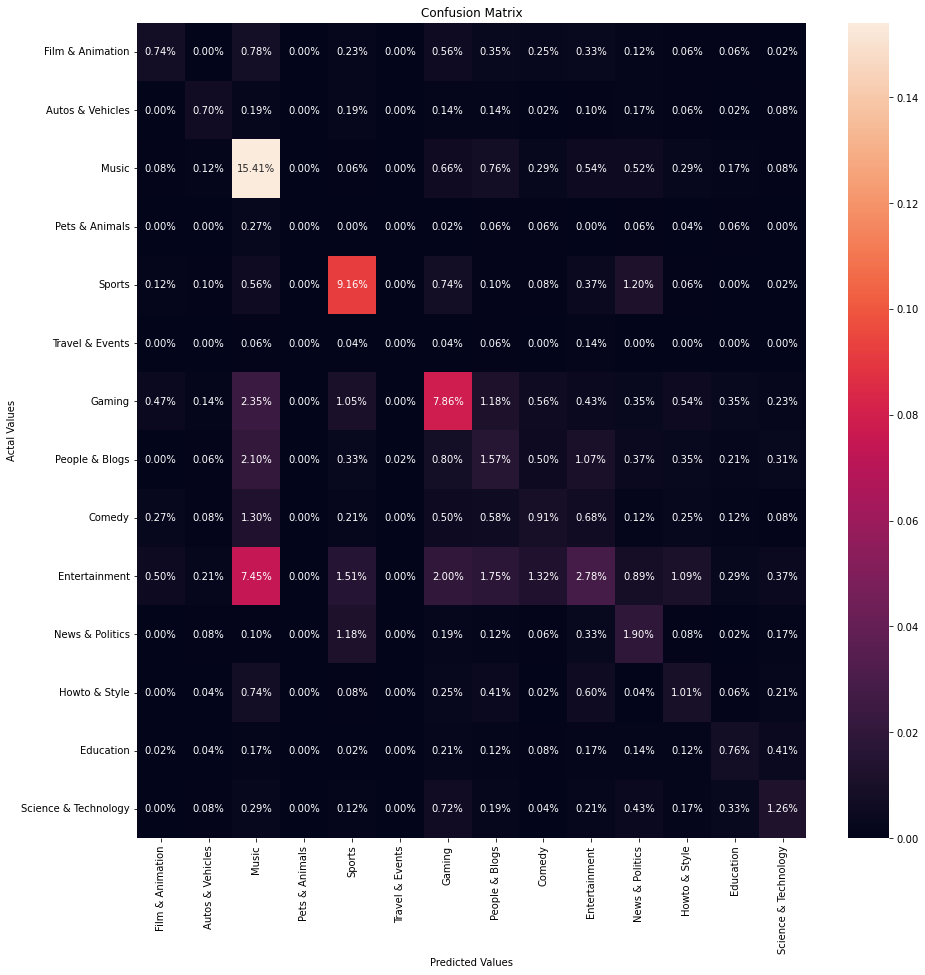

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=labels)


plt.figure(figsize=(15,15))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', xticklabels = labels_with_names, yticklabels=labels_with_names)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<font size="5"><b>Self-training + SMOTE. Połączenie 3 najmniej licznych kategorii</b></font>

In [42]:
#Połączenie 3 najmniej licznych kategorii
for index, row in df.iterrows():
    if row['org_categories'] in [2.0, 15.0, 19.0]:
        df['org_categories'][index] = 0
    if row['ground_truth'] in [2.0, 15.0, 19.0]:
        df['ground_truth'][index] = 0

C:\Users\skibi\AppData\Local\Temp/ipykernel_4028/1519175875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ground_truth'][index] = 0
C:\Users\skibi\AppData\Local\Temp/ipykernel_4028/1519175875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['org_categories'][index] = 0


In [43]:
#przygotowanie danych pod trening
labeled = df[df['org_categories'] == df['org_categories']]
unlabeled = df[df['org_categories'] != df['org_categories']]

#dane treningowe etykietowane
X_train_lab = labeled.drop(['org_categories', 'ground_truth'], axis=1)
y_train_lab = labeled['org_categories']

#dane treningowe i testowe nieetykietowane (wydzielenie z danych nieetykietowanych na te do treningu oraz do testów [ground truth])
X_train_unlab, X_test, y_train_unlab, y_test = train_test_split(unlabeled.drop(['org_categories', 'ground_truth'], axis=1), unlabeled[['org_categories', 'ground_truth']], test_size=0.5, random_state=42)
y_train_unlab = y_train_unlab['org_categories']
y_test = y_test['ground_truth']

#usunięcie wartosci nan ze zbiorow testowych
for index, value in y_test.items():
     if value != value:
        y_test.drop(index, inplace = True)
        X_test.drop(index, inplace = True)  
        
#LabelPropagation wymaga, aby unlabeled y posiadał wartości -1
y_train_unlab = y_train_unlab.fillna(-1)

#SMOTE
oversample = SMOTE()
X_train_lab_over, y_train_lab_over = oversample.fit_resample(X_train_lab, y_train_lab)


#zbiory treningowe i testowe ze zbiorow etykietowanych i nieetykietowanych
X_train = concatenate((X_train_lab, X_train_unlab))
y_train = concatenate((y_train_lab, y_train_unlab))

print("Etykietowany zbiór uczący: ",  X_train_lab.shape, y_train_lab.shape)
print("Nieetykietowany zbiór uczący: ", X_train_unlab.shape, y_train_unlab.shape)
print("Zbiór testowy: ", X_test.shape, y_test.shape)

Etykietowany zbiór uczący:  (2517, 46) (2517,)
Nieetykietowany zbiór uczący:  (4991, 46) (4991,)
Zbiór testowy:  (4851, 46) (4851,)


In [47]:
model_svc = SVC(kernel='rbf', 
                probability=True, 
                random_state=0
               )

self_training_model = SelfTrainingClassifier(base_estimator=model_svc, 
                                             threshold=0.7, 
                                             criterion='threshold', 
                                             max_iter=100, 
                                             verbose=True 
                                            )

self_training_model.fit(X_train, y_train)

End of iteration 1, added 162 new labels.
End of iteration 2, added 215 new labels.
End of iteration 3, added 187 new labels.
End of iteration 4, added 101 new labels.
End of iteration 5, added 43 new labels.
End of iteration 6, added 16 new labels.
End of iteration 7, added 14 new labels.
End of iteration 8, added 6 new labels.
End of iteration 9, added 2 new labels.
End of iteration 10, added 1 new labels.


SelfTrainingClassifier(base_estimator=SVC(probability=True, random_state=0),
                       max_iter=100, threshold=0.7, verbose=True)

In [48]:
y_pred = self_training_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
gmean = geometric_mean_score(y_test, y_pred, average='weighted')
print("Accuracy score: ", score)
print("G-mean score: ", gmean)

C:\Users\skibi\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Accuracy score:  0.45248402391259535
G-mean score:  0.6331619027471462


In [50]:
labels = [ 0.,  1., 10., 17., 20., 22., 23., 24., 25., 26., 27., 28.]
scores = geometric_mean_score(y_test, y_pred, average=None, labels = labels)
for score, label in zip(scores, labels):
    print('Kategoria: ', label, ' Wynik: ', score)

Kategoria:  0.0  Wynik:  0.5262672608759993
Kategoria:  1.0  Wynik:  0.30576846041234745
Kategoria:  10.0  Wynik:  0.8170596793610995
Kategoria:  17.0  Wynik:  0.8534610148722809
Kategoria:  20.0  Wynik:  0.6790083831137002
Kategoria:  22.0  Wynik:  0.18608287978600163
Kategoria:  23.0  Wynik:  0.1422157787949198
Kategoria:  24.0  Wynik:  0.5400857979328212
Kategoria:  25.0  Wynik:  0.4337690168611177
Kategoria:  26.0  Wynik:  0.0
Kategoria:  27.0  Wynik:  0.3558489065953874
Kategoria:  28.0  Wynik:  0.5205389774296215


In [53]:
#zmiana indeksów na nazwy kategorii
with open("US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
category=[]
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]

cat_dict[0] = "Other"
#df_features = features.copy()
#df_features['cat_name'] = features['ground_truth'].map(cat_dict)

labels_with_names = [*map(cat_dict.get, labels)]
labels_with_names

['Other',
 'Film & Animation',
 'Music',
 'Sports',
 'Gaming',
 'People & Blogs',
 'Comedy',
 'Entertainment',
 'News & Politics',
 'Howto & Style',
 'Education',
 'Science & Technology']

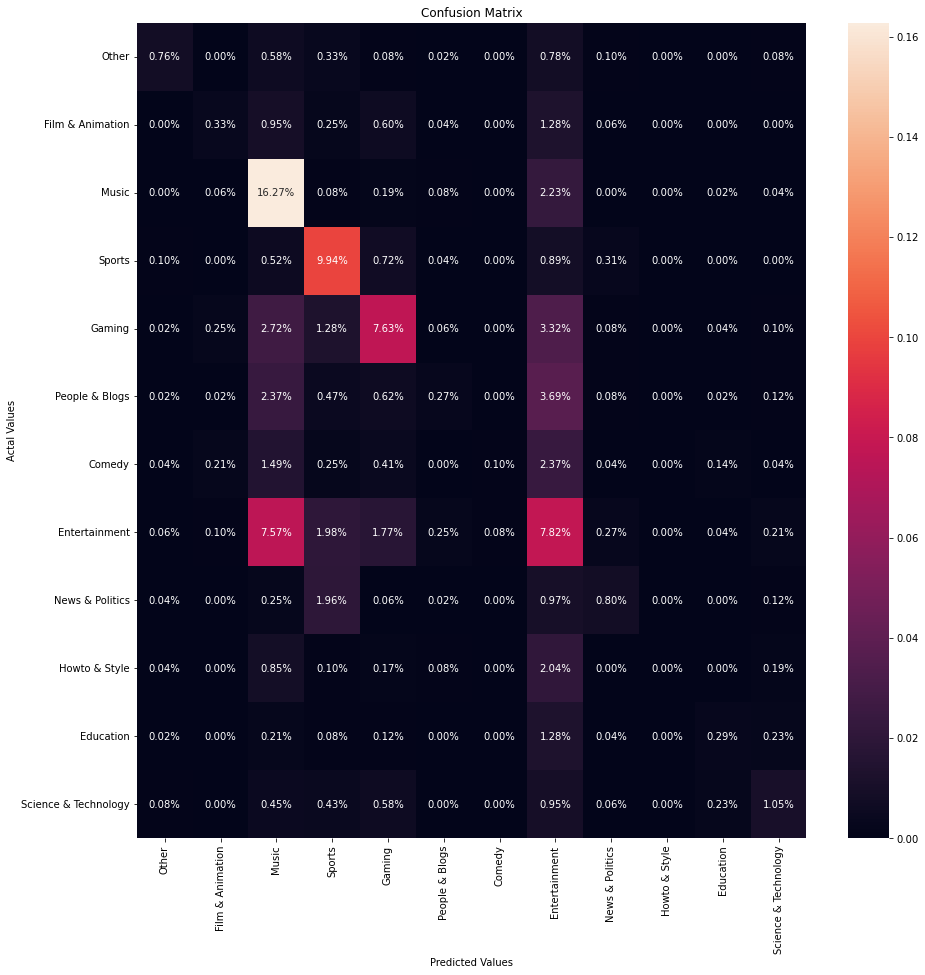

In [54]:
cm = confusion_matrix(y_test, y_pred, labels=labels)


plt.figure(figsize=(15,15))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', xticklabels = labels_with_names, yticklabels=labels_with_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Zastosowanie Random Oversampling minimalnie pogorszyło wynik Self-traing'u. 
Jeżeli chodzi o zastosowanie SMOTE, to wynik niezauważalnie się poprawił w stosunku do danych niezbalansowanych. 
W macierzy pomyłek można za to było zauważyć, że kategorie o numerach 15 oraz 19 (czyli odpowiednio "Pets & Animals" oraz "Travel & Events") były przypisywane z zerową skutecznością. Są to jednak klasy mniejszościowe. Usunąłem zatem ponownie 3 najmniej liczne klasy (a właściwie przypisałem je do kategorii "Other"). Co ciekawe wynik nie poprawił się, a obecnie kategoria klasyfikowana z zerową skutecznością to "Howto & Style". Można również zauważyć sporo pomyłek w kategoriach "Music" oraz "Entertaiment" (a zwłaszca pomiędzy nimi). Są one zbliżone do siebie, zatem pomyłki w tej kwestii są zrozumiałe.  